In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Exercise 1

In [27]:
def simulate_sir_simple(lam, mu, I_0, T):
    # initialize arrays for S, I, R
    S = np.zeros(T+1)
    I = np.zeros(T+1)
    R = np.zeros(T+1)
    # define odes for S, I, R
    def dS(S, I):
        return -lam*S*I
    def dI(S, I):
        return lam*S*I - mu*I
    def dR(I):
        return mu*I
    
    # initial conditions
    S[0] = 1 - I_0
    I[0] = I_0

    # simulate the ODEs
    for t in range(T):
        S[t+1] = S[t] + dS(S[t], I[t])
        I[t+1] = I[t] + dI(S[t], I[t])
        R[t+1] = R[t] + dR(I[t])

    # calculate the daily changes
    delta_S = np.zeros(T)
    delta_R = np.zeros(T)
    for t in range(1, T):
        delta_S[t] = S[t-1] - S[t]
        delta_R[t] = R[t-1] - R[t]

    X = np.array([(delta_S[i], delta_R[i]) for i in range(T)])
    C = np.array([(S[i], I[i], R[i]) for i in range(T)])
    return X

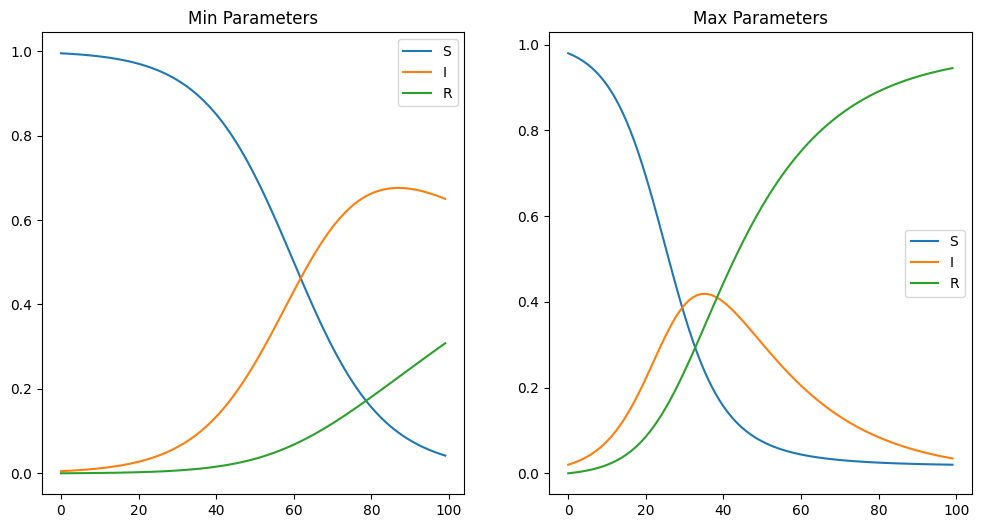

In [ ]:
# plot the min and max parameters to see, for the later prior definition  (the C is removed from the function output, add to test new parameters)
def plot_sir(lam_min, lam_max, mu_min, mu_max, I0_min, I0_max, T=100):
    # simulate min parameters 
    _ , C_min = simulate_sir_simple(lam_min, mu_min, I0_min, T)

    # simulate max parameters
    _ , C_max = simulate_sir_simple(lam_max, mu_max, I0_max, T)

    # plot 
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(C_min[:, 0], label='S')
    ax[0].plot(C_min[:, 1], label='I')
    ax[0].plot(C_min[:, 2], label='R')
    ax[0].set_title('Min Parameters')
    ax[0].legend()
    ax[1].plot(C_max[:, 0], label='S')
    ax[1].plot(C_max[:, 1], label='I')
    ax[1].plot(C_max[:, 2], label='R')
    ax[1].set_title('Max Parameters')
    ax[1].legend()
    plt.show()

plot_sir(0.1, 0.2, 0.01, 0.05, 0.005, 0.02)


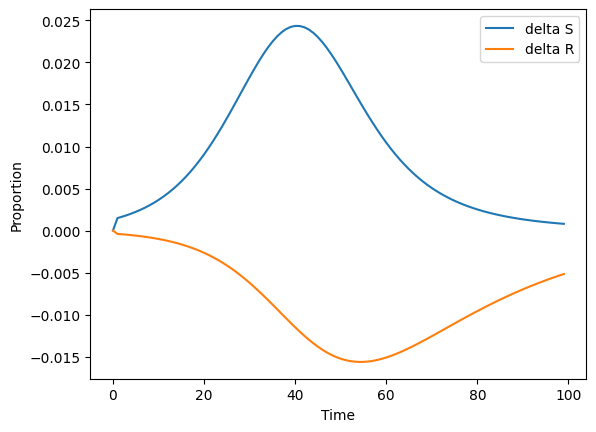

In [38]:
# parameters 
lam = 0.15
mu = 0.04
I_0 = 0.01
T = 100

# simulate
X, C = simulate_sir_simple(lam, mu, I_0, T)

plt.plot(X[:, 0], label='delta S')
plt.plot(X[:, 1], label='delta R')
plt.xlabel('Time')
plt.ylabel('Proportion')
plt.legend()
plt.show()

In [ ]:
# define the prior distribution for the simulation parameters
def prior_distribution(num_samples):
    lam = np.random.uniform(0.1, 0.2, num_samples)
    mu = np.random.uniform(0.01, 0.05, num_samples)
    I_0 = np.random.uniform(0.005, 0.02, num_samples)
    return np.array(list(zip(lam, mu, I_0)))

In [16]:
# define a feed forward neural network
class FeedForward(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(FeedForward, self).__init__()
        layers = []
        layer_size = input_size
        for i in range(num_layers):
            layers.append(nn.Linear(layer_size, hidden_size))
            layers.append(nn.ReLU())
            layer_size = hidden_size
        layers.append(nn.Linear(layer_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [19]:
def train_feedforward(model, simulation, priors, epochs, lr, batch_size):
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # train the model
    for epoch in range(epochs):
        samples = priors(batch_size)
        X = np.array([simulation(*sample, 100) for sample in samples])
        X = torch.tensor(X, dtype=torch.float32).to(device)
        samples = torch.tensor(samples, dtype=torch.float32).to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        y_pred = model(X)
        # calculate the loss
        loss = loss_fn(y_pred, samples)
        # backward pass
        loss.backward()
        # optimize
        optimizer.step()
        # print the loss
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss {loss.item()}')